In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tusharjain3118017","key":"8d864711ed53a69aa67cf2b615195b4c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.29G/9.29G [03:13<00:00, 40.3MB/s]



In [ ]:
from zipfile import ZipFile
file_name = 'rsna-bone-age.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
folder_train = '/content/boneage-training-dataset/boneage-training-dataset'
folder_test = '/content/boneage-test-dataset/boneage-test-dataset'

In [ ]:
age_df = pd.read_csv('/content/boneage-training-dataset.csv')
age_df['path'] = age_df['id'].map(lambda x: os.path.join(folder_train, '{}.png'.format(x)))
age_df['imagepath'] = age_df['id'].map(lambda x: '{}.png'.format(x))
age_df['boneage'] = age_df['boneage'].astype('float64')
bone_age_mean = age_df['boneage'].mean()
bone_age_dev = 2 * age_df['boneage'].std()
age_df['boneage_score'] = age_df.boneage.map(lambda x: (x - bone_age_mean)/bone_age_dev)
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
age_df['gender'] = age_df['gender'].map(lambda x: 1.0 if x=='male' else 0.0)
age_df.head()

,id,boneage,male,path,imagepath,boneage_score,gender
0,1377,180.0,False,/content/boneage-training-dataset/boneage-trai...,1377.png,0.639590,0.0
1,1378,12.0,False,/content/boneage-training-dataset/boneage-trai...,1378.png,-1.400135,0.0
2,1379,94.0,False,/content/boneage-training-dataset/boneage-trai...,1379.png,-0.404555,0.0
3,1380,120.0,True,/content/boneage-training-dataset/boneage-trai...,1380.png,-0.088883,1.0
4,1381,82.0,False,/content/boneage-training-dataset/boneage-trai...,1381.png,-0.550249,0.0


In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_valid = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2022)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.15, horizontal_flip=True,
                                   vertical_flip = False, fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                               directory = folder_train,
                                               x_col='imagepath',
                                               y_col='boneage_score', 
                                               target_size=(224,224),
                                               batch_size = 32, color_mode = 'rgb',
                                               class_mode = 'raw')
test_set = test_datagen.flow_from_dataframe(dataframe = df_valid,
                                               directory = folder_train,
                                               x_col='imagepath',
                                               y_col='boneage_score', 
                                               target_size=(224,224),
                                               batch_size = 32, color_mode = 'rgb',
                                               class_mode = 'raw')

Found 9458 validated image filenames.
Found 3153 validated image filenames.


In [ ]:
train_img_mnet, train_lbl_mnet = next(train_set)
valid_img_mnet, valid_lbl_mnet = next(test_set)

In [ ]:
train_X, train_Y = next(train_datagen.flow_from_dataframe(dataframe=df_train, 
                                            directory=folder_train, 
                                            x_col='imagepath', 
                                            y_col='boneage_score', 
                                            class_mode = 'raw',
                                            color_mode = 'rgb',
                                            target_size=(224, 224), 
                                            batch_size=1024))

Found 9458 validated image filenames.


In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
import tensorflow as tf

base_model=MobileNet(input_shape =  train_img_mnet.shape[1:],weights='imagenet',include_top=False)

base_mobilenet_model=base_model.output
base_mobilenet_model=GlobalAveragePooling2D()(base_mobilenet_model)
base_mobilenet_model=Dense(1024,activation='relu')(base_mobilenet_model) 
base_mobilenet_model=Dense(1024,activation='relu')(base_mobilenet_model) 
base_mobilenet_model=Dense(512,activation='relu')(base_mobilenet_model) 
output1=Dense(1,activation='linear')(base_mobilenet_model) 
rsna_mobilenet=Model(inputs=base_model.input,outputs=output1)
for layer in rsna_mobilenet.layers:
    layer.trainable=False

In [ ]:
rsna_mobilenet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
rsna_mobilenet.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_mnet_weights.h5".format('bone_age')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', min_delta=0.01, cooldown=3, min_lr=0.01)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
train_size=np.ceil(train_set.n//train_set.batch_size)
valid_size=np.ceil(test_set.n//test_set.batch_size)

In [ ]:
history_mobilenet = rsna_mobilenet.fit(train_set,
                    steps_per_epoch=train_size,
                    validation_data=test_set,
                    validation_steps=valid_size,
                    epochs=50, 
                    callbacks = callbacks_list)

Epoch 1/50
295/295 [==============================] - ETA: 0s - loss: 0.5709 - mae: 0.5885
Epoch 00001: val_loss improved from inf to 0.50581, saving model to bone_age_mnet_weights.h5
295/295 [==============================] - 593s 2s/step - loss: 0.5709 - mae: 0.5885 - val_loss: 0.5058 - val_mae: 0.5409 - lr: 0.0010
Epoch 2/50
295/295 [==============================] - ETA: 0s - loss: 0.5649 - mae: 0.5854
Epoch 00002: val_loss improved from 0.50581 to 0.50450, saving model to bone_age_mnet_weights.h5
295/295 [==============================] - 567s 2s/step - loss: 0.5649 - mae: 0.5854 - val_loss: 0.5045 - val_mae: 0.5404 - lr: 0.0010
Epoch 3/50
295/295 [==============================] - ETA: 0s - loss: 0.5712 - mae: 0.5896
Epoch 00003: val_loss improved from 0.50450 to 0.50285, saving model to bone_age_mnet_weights.h5
295/295 [==============================] - 569s 2s/step - loss: 0.5712 - mae: 0.5896 - val_loss: 0.5028 - val_mae: 0.5394 - lr: 0.0010
Epoch 4/50
295/295 [===============

In [ ]:
val_pred_Y = (bone_age_dev*rsna_mobilenet.predict(train_X, batch_size = 64, verbose = True))+bone_age_mean
val_Y_months = (bone_age_dev*train_Y)+bone_age_mean

16/16 [==============================] - 4s 163ms/step


Text(0, 0.5, 'Predicted Age (Months)')

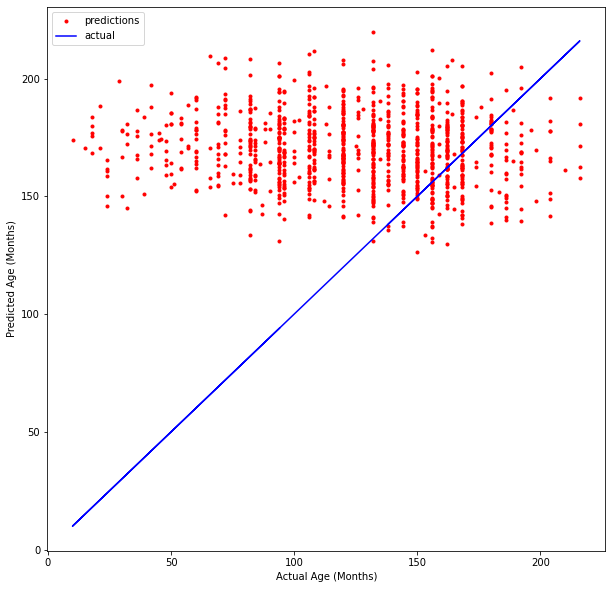

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (10,10))
ax1.plot(val_Y_months, val_pred_Y, 'r.', label = 'predictions')
ax1.plot(val_Y_months, val_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [ ]:
rsna_mobilenet.save('mobilenet.h5')